In [1]:
pip install ultralytics matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existin

In [29]:
# from pathlib import Path
# import os
# import shutil
# import random
# from collections import defaultdict

# # Dataset root (already unzipped by Kaggle)
# dataset_path = Path("/kaggle/input/final-2-v5i-yolov8-zip")
# train_path = dataset_path / "train"
# images_path = train_path / "images"
# labels_path = train_path / "labels"

# # Output working path
# working_path = Path("/kaggle/working")
# balanced_path = working_path / "balanced_dataset"


IsADirectoryError: [Errno 21] Is a directory: '/kaggle/input/final-2-v5i-yolov8-zip'

In [30]:
import os
from pathlib import Path
import shutil
import random
from collections import defaultdict

# Kaggle dataset path (auto-mounted)
dataset_path = Path('/kaggle/input/final-2-v5i-yolov8-zip')

# We'll copy the dataset locally to /kaggle/working for write access
local_data_path = Path('/kaggle/working/dataset')
if local_data_path.exists():
    shutil.rmtree(local_data_path)
shutil.copytree(dataset_path / 'train', local_data_path / 'train')

# Copy data.yaml also
shutil.copy(dataset_path / 'data.yaml', local_data_path / 'data.yaml')

print("✅ Dataset copied to working directory:", local_data_path)


✅ Dataset copied to working directory: /kaggle/working/dataset


In [38]:
def split_dataset(base_path, train_ratio=0.7, val_ratio=0.2):
    image_dir = base_path / "train" / "images"
    label_dir = base_path / "train" / "labels"

    all_images = list(image_dir.glob("*.jpg"))
    random.shuffle(all_images)

    total = len(all_images)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)

    splits = {
        'train': all_images[:train_end],
        'valid': all_images[train_end:val_end],
        'test': all_images[val_end:]
    }

    for split, files in splits.items():
        for subfolder in ["images", "labels"]:
            (base_path / split / subfolder).mkdir(parents=True, exist_ok=True)

        for img_path in files:
            label_path = label_dir / f"{img_path.stem}.txt"
            dst_img = base_path / split / "images" / img_path.name
            if img_path.resolve() != dst_img.resolve():
                shutil.copy(img_path, dst_img)

            dst_label = base_path / split / "labels" / label_path.name
            if label_path.exists() and label_path.resolve() != dst_label.resolve():
                shutil.copy(label_path, dst_label)

    print(f"✅ Dataset split: train={len(splits['train'])}, valid={len(splits['valid'])}, test={len(splits['test'])}")

split_dataset(local_data_path)

✅ Dataset split: train=2064, valid=589, test=296


Balance training classes (duplicate minority class images)

In [39]:
def balance_classes(images_dir, labels_dir):
    from collections import defaultdict
    import random
    import shutil
    from pathlib import Path

    class_to_images = defaultdict(list)

    for label_file in Path(labels_dir).glob("*.txt"):
        with open(label_file, 'r') as f:
            lines = f.readlines()
            classes_in_file = set()
            for line in lines:
                cls = int(line.split()[0])
                classes_in_file.add(cls)
            for cls in classes_in_file:
                class_to_images[cls].append(label_file.stem)

    max_count = max(len(v) for v in class_to_images.values())
    print(f"Balancing classes to {max_count} images per class.")

    balanced_images = set()

    for cls, stems in class_to_images.items():
        needed = max_count - len(stems)
        print(f"Class {cls} has {len(stems)} images, need {needed} more.")

        balanced_images.update(stems)

        if needed > 0:
            sampled = random.choices(stems, k=needed)
            for stem in sampled:
                new_stem = f"{stem}_aug{random.randint(1000, 9999)}"
                orig_img = Path(images_dir) / f"{stem}.jpg"
                new_img = Path(images_dir) / f"{new_stem}.jpg"
                shutil.copy(orig_img, new_img)

                orig_lbl = Path(labels_dir) / f"{stem}.txt"
                new_lbl = Path(labels_dir) / f"{new_stem}.txt"
                shutil.copy(orig_lbl, new_lbl)

                balanced_images.add(new_stem)

    print(f"✅ Balanced dataset size: {len(balanced_images)} images")

balance_classes(
    images_dir=str(local_data_path / "train" / "images"),
    labels_dir=str(local_data_path / "train" / "labels")
)

Balancing classes to 486 images per class.
Class 8 has 303 images, need 183 more.
Class 0 has 225 images, need 261 more.
Class 1 has 183 images, need 303 more.
Class 7 has 252 images, need 234 more.
Class 3 has 234 images, need 252 more.
Class 9 has 486 images, need 0 more.
Class 5 has 258 images, need 228 more.
Class 10 has 333 images, need 153 more.
Class 6 has 243 images, need 243 more.
Class 2 has 210 images, need 276 more.
Class 4 has 249 images, need 237 more.
✅ Balanced dataset size: 5309 images


In [40]:
import yaml

def update_data_yaml_paths(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    data['train'] = 'train/images'
    data['val'] = 'valid/images'
    data['test'] = 'test/images'

    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)

    print(f"✅ Updated YAML paths in '{yaml_path}'")

update_data_yaml_paths(local_data_path / "data.yaml")

✅ Updated YAML paths in '/kaggle/working/dataset/data.yaml'


In [41]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # change to yolov8s.pt or others if needed

model.train(
    data=str(local_data_path / "data.yaml"),
    epochs=15,
    imgsz=640,
    batch=16,
    project="threat_detection_project",
    name="yolov8_balanced_training",
    val=True
)

Ultralytics 8.3.136 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/data.yaml, degrees=0.0, deterministic=True, device=-1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_balanced_training, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

train: Scanning /kaggle/working/dataset/train/labels... 5318 images, 9 backgrounds, 0 corrupt: 100%|██████████| 5318/5318 [00:03<00:00, 1458.58it/s]


train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 549.0±349.4 MB/s, size: 47.1 KB)


val: Scanning /kaggle/working/dataset/valid/labels... 589 images, 0 backgrounds, 0 corrupt: 100%|██████████| 589/589 [00:00<00:00, 683.26it/s]

val: New cache created: /kaggle/working/dataset/valid/labels.cache


Plotting labels to threat_detection_project/yolov8_balanced_training/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to threat_detection_project/yolov8_balanced_training
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      2.37G      1.062      3.105      1.549         16        640: 100%|██████████| 333/333 [01:03<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.18it/s]


                   all        589        641      0.287      0.515      0.301      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      2.61G      1.052      2.371      1.518         12        640: 100%|██████████| 333/333 [01:00<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]

                   all        589        641       0.38      0.529      0.461      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      2.61G      1.037      2.086      1.497         12        640: 100%|██████████| 333/333 [01:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]

                   all        589        641       0.49      0.607      0.501      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      2.61G      1.006      1.873       1.47         16        640: 100%|██████████| 333/333 [00:59<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.45it/s]

                   all        589        641      0.516      0.635      0.596      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      2.61G     0.9615      1.706      1.424         14        640: 100%|██████████| 333/333 [00:59<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.59it/s]

                   all        589        641      0.562      0.642      0.641      0.424


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      2.61G      0.943      1.515      1.537          7        640: 100%|██████████| 333/333 [01:00<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.52it/s]

                   all        589        641       0.65      0.753       0.76       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      2.61G      0.874      1.287      1.467          6        640: 100%|██████████| 333/333 [00:59<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]

                   all        589        641      0.711       0.73      0.784      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      2.61G     0.8273      1.139      1.422          6        640: 100%|██████████| 333/333 [00:59<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]

                   all        589        641      0.802      0.703      0.835      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      2.61G     0.7862      1.012      1.377          6        640: 100%|██████████| 333/333 [00:59<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.78it/s]

                   all        589        641      0.817      0.832      0.894      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      2.62G     0.7223     0.8945      1.315          6        640: 100%|██████████| 333/333 [00:59<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.07it/s]

                   all        589        641      0.799      0.837      0.898      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      2.64G     0.6995     0.8158      1.299          8        640: 100%|██████████| 333/333 [00:59<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.14it/s]

                   all        589        641      0.907      0.877      0.945      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      2.66G     0.6713      0.724      1.263          8        640: 100%|██████████| 333/333 [01:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.01it/s]

                   all        589        641      0.919      0.913      0.965      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      2.68G     0.6316     0.6616      1.229          7        640: 100%|██████████| 333/333 [00:59<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.07it/s]

                   all        589        641      0.952      0.932      0.974      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      2.69G     0.5929     0.6011      1.194          6        640: 100%|██████████| 333/333 [00:59<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.14it/s]

                   all        589        641      0.958      0.932      0.976      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      2.71G     0.5623     0.5486      1.171          6        640: 100%|██████████| 333/333 [00:59<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.09it/s]

                   all        589        641      0.977      0.952      0.985       0.84



15 epochs completed in 0.267 hours.
Optimizer stripped from threat_detection_project/yolov8_balanced_training/weights/last.pt, 6.2MB
Optimizer stripped from threat_detection_project/yolov8_balanced_training/weights/best.pt, 6.2MB

Validating threat_detection_project/yolov8_balanced_training/weights/best.pt...
Searching for 1 idle GPUs with >= 2048 MiB free memory...
Selected idle CUDA devices [0]
Ultralytics 8.3.136 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.34it/s]


                   all        589        641      0.976      0.951      0.985      0.841
         civilian_auto         46         52          1       0.95      0.994      0.788
          civilian_bus         35         41      0.975          1      0.995      0.869
        civilian_tempo         44         47          1      0.974      0.995      0.831
      civilian_tractor         39         40      0.953        0.9      0.966      0.781
        civilian_truck         61         73      0.994      0.959       0.99      0.749
               safe_av         47         48      0.974      0.938      0.986      0.877
            safe_tanks         55         58       0.97      0.966      0.985      0.844
            safe_truck         45         48      0.963      0.938       0.96      0.867
             threat_av         58         58      0.989      0.931      0.992      0.894
           threat_tank         95         99      0.979      0.937      0.985      0.866
          threat_truc

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to threat_detection_project/yolov8_balanced_training


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b2d10fb0c10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.

In [42]:
model.save("yolov8_balanced.pt")
print("✅ Model saved as yolov8_balanced.pt")

✅ Model saved as yolov8_balanced.pt


In [58]:
model = YOLO("/kaggle/working/yolov8_balanced.pt")
model.export(format="torchscript")  # ✅ This is supported!

Ultralytics 8.3.136 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/kaggle/working/yolov8_balanced.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 15, 8400) (6.0 MB)

TorchScript: starting export with torch 2.6.0+cu124...
TorchScript: export success ✅ 1.8s, saved as '/kaggle/working/yolov8_balanced.torchscript' (11.9 MB)

Export complete (2.3s)
Results saved to /kaggle/working
Predict:         yolo predict task=detect model=/kaggle/working/yolov8_balanced.torchscript imgsz=640  
Validate:        yolo val task=detect model=/kaggle/working/yolov8_balanced.torchscript imgsz=640 data=/kaggle/working/dataset/data.yaml  
Visualize:       https://netron.app


'/kaggle/working/yolov8_balanced.torchscript'

✅ Found: /kaggle/working/threat_detection_project/yolov8_balanced_training/results.csv


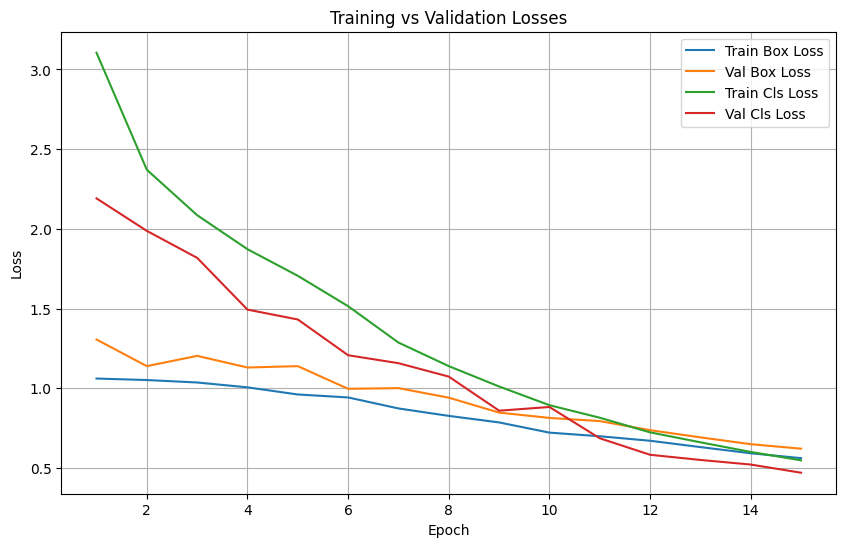

In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def find_results_csv(search_dir="/kaggle/working"):
    for root, dirs, files in os.walk(search_dir):
        for file in files:
            if file == "results.csv":
                print("✅ Found:", os.path.join(root, file))
                return os.path.join(root, file)
    raise FileNotFoundError("❌ results.csv not found.")

def plot_all_losses(csv_path):
    df = pd.read_csv(csv_path)
    epochs = df['epoch']

    plt.figure(figsize=(10,6))
    plt.plot(epochs, df['train/box_loss'], label='Train Box Loss')
    plt.plot(epochs, df['val/box_loss'], label='Val Box Loss')
    plt.plot(epochs, df['train/cls_loss'], label='Train Cls Loss')
    plt.plot(epochs, df['val/cls_loss'], label='Val Cls Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

csv_path = find_results_csv()
plot_all_losses(csv_path)

In [63]:
model = YOLO("/kaggle/working/yolov8_balanced.pt")

metrics = model.val(data=str(data_yaml), split='test')

print("✅ Evaluation Results:")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")

precision = sum(metrics.box.p) / len(metrics.box.p)
recall = sum(metrics.box.r) / len(metrics.box.r)
f1 = sum(metrics.box.f1) / len(metrics.box.f1)

print(f"Precision (mean): {precision:.4f}")
print(f"Recall (mean): {recall:.4f}")
print(f"F1-score (mean): {f1:.4f}")

Ultralytics 8.3.136 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1241.4±304.4 MB/s, size: 61.5 KB)


val: Scanning /kaggle/working/balanced_dataset/test/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]


                   all        200        220      0.965      0.959      0.987       0.84
         civilian_auto         21         22      0.956      0.955      0.992      0.812
          civilian_bus         17         20      0.964          1      0.995      0.831
        civilian_tempo         20         22      0.983      0.955      0.985      0.817
      civilian_tractor         19         20          1      0.999      0.995      0.821
        civilian_truck         17         21      0.993      0.952      0.977      0.687
               safe_av         20         20       0.99          1      0.995      0.856
            safe_tanks         24         24      0.993          1      0.995      0.914
            safe_truck         18         21      0.914      0.905      0.985      0.882
             threat_av         10         11      0.973      0.909      0.967      0.853
           threat_tank         18         18      0.946      0.968      0.992      0.868
          threat_truc

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.6ms preprocess, 2.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val2
✅ Evaluation Results:
mAP50: 0.9872
mAP50-95: 0.8403
Precision (mean): 0.9655
Recall (mean): 0.9588
F1-score (mean): 0.9620


In [64]:
recall = 0.9588
precision = 0.9655
total_gt = 220

correct = recall * total_gt
false_pos = correct * (1 / precision - 1)
accuracy = correct / (correct + false_pos)
print(f"Approximate Accuracy: {accuracy:.4f}")

Approximate Accuracy: 0.9655


In [51]:
# balanced_path.mkdir(parents=True, exist_ok=True)
# for sub in ["images", "labels"]:
#     (balanced_path / sub).mkdir(parents=True, exist_ok=True)

# class_images = defaultdict(list)

# for label_file in labels_path.glob("*.txt"):
#     with open(label_file, "r") as f:
#         lines = f.readlines()
#         classes = set(line.split()[0] for line in lines)
#     for cls in classes:
#         image_file = images_path / f"{label_file.stem}.jpg"
#         if image_file.exists():
#             class_images[cls].append((image_file, label_file))

# min_samples = min(len(files) for files in class_images.values())
# print(f"💡 Balancing to {min_samples} images per class.")

# balanced_images = []
# for cls, files in class_images.items():
#     balanced = random.sample(files, min_samples)
#     balanced_images.extend(balanced)

# for img_path, lbl_path in balanced_images:
#     shutil.copy(img_path, balanced_path / "images" / img_path.name)
#     shutil.copy(lbl_path, balanced_path / "labels" / lbl_path.name)

# print("✅ Balanced dataset created.")

In [20]:
# def split_dataset(base_path, train_ratio=0.7, val_ratio=0.2):
#     image_dir = base_path / "images"
#     label_dir = base_path / "labels"
#     all_images = list(image_dir.glob("*.jpg"))
#     random.shuffle(all_images)

#     total = len(all_images)
#     train_end = int(train_ratio * total)
#     val_end = train_end + int(val_ratio * total)

#     splits = {
#         'train': all_images[:train_end],
#         'valid': all_images[train_end:val_end],
#         'test': all_images[val_end:]
#     }

#     for split, files in splits.items():
#         for sub in ["images", "labels"]:
#             (base_path / split / sub).mkdir(parents=True, exist_ok=True)
#         for img in files:
#             lbl = label_dir / f"{img.stem}.txt"
#             shutil.copy(img, base_path / split / "images" / img.name)
#             shutil.copy(lbl, base_path / split / "labels" / lbl.name)

# split_dataset(balanced_path)
# print("✅ Dataset split into train/valid/test.")

✅ Dataset split into train/valid/test.


In [22]:
# from pathlib import Path

# split_base = Path("/kaggle/working/balanced_dataset")

# for split in ["train", "valid", "test"]:
#     image_dir = split_base / split / "images"
#     count = len(list(image_dir.glob("*.jpg")))
#     print(f"{split.capitalize()} images: {count}")

Train images: 1393
Valid images: 398
Test images: 200


In [21]:
# data_yaml = balanced_path / "data.yaml"
# with open(data_yaml, "w") as f:
#     f.write(f"""train: {balanced_path}/train/images
# val: {balanced_path}/valid/images
# test: {balanced_path}/test/images

# nc: 11
# names: ['civilian_auto', 'civilian_bus', 'civilian_tempo', 'civilian_tractor', 'civilian_truck',
#         'safe_av', 'safe_tanks', 'safe_truck', 'threat_av', 'threat_tank', 'threat_truck']
# """)

# print("📄 YAML created at:", data_yaml)

📄 YAML created at: /kaggle/working/balanced_dataset/data.yaml


In [23]:
# from ultralytics import YOLO

# model = YOLO("yolov8n.pt")  # or yolov8s.pt

# model.train(
#     data=str(data_yaml),
#     epochs=15,
#     imgsz=640,
#     batch=16,
#     project="threat_balanced_training",
#     name="yolov8_balanced",
#     val=True
# )

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 112MB/s]


Ultralytics 8.3.136 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/balanced_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_balanced, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.

100%|██████████| 755k/755k [00:00<00:00, 30.3MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 123MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1520.6±408.2 MB/s, size: 59.3 KB)


train: Scanning /kaggle/working/balanced_dataset/train/labels... 1393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1393/1393 [00:00<00:00, 1525.51it/s]

train: New cache created: /kaggle/working/balanced_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 420.1±143.1 MB/s, size: 61.2 KB)


val: Scanning /kaggle/working/balanced_dataset/valid/labels... 398 images, 0 backgrounds, 0 corrupt: 100%|██████████| 398/398 [00:00<00:00, 933.63it/s] 

val: New cache created: /kaggle/working/balanced_dataset/valid/labels.cache


Plotting labels to threat_balanced_training/yolov8_balanced/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to threat_balanced_training/yolov8_balanced
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      2.22G      1.088      3.585      1.584          3        640: 100%|██████████| 88/88 [00:17<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]


                   all        398        425      0.461      0.341      0.156     0.0952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      2.48G       1.08      2.947        1.6          2        640: 100%|██████████| 88/88 [00:15<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.44it/s]

                   all        398        425      0.212      0.408      0.244      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      2.49G      1.094      2.682      1.565          3        640: 100%|██████████| 88/88 [00:15<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.52it/s]

                   all        398        425      0.168      0.487      0.215      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      2.51G      1.084      2.544      1.569          3        640: 100%|██████████| 88/88 [00:15<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.81it/s]

                   all        398        425      0.349      0.451      0.335      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      2.52G      1.072      2.428      1.551          2        640: 100%|██████████| 88/88 [00:15<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.64it/s]

                   all        398        425      0.354      0.533       0.38      0.227


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      2.54G      1.051      2.639      1.679          1        640: 100%|██████████| 88/88 [00:16<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


                   all        398        425       0.32       0.56      0.355      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      2.56G      1.036      2.437      1.626          2        640: 100%|██████████| 88/88 [00:15<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.78it/s]

                   all        398        425      0.373      0.586      0.411      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      2.57G     0.9843      2.222      1.605          1        640: 100%|██████████| 88/88 [00:15<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.45it/s]

                   all        398        425       0.47      0.518      0.489      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      2.59G     0.9586       2.06      1.575          1        640: 100%|██████████| 88/88 [00:15<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.89it/s]

                   all        398        425      0.441      0.622      0.528      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      2.61G     0.8935      1.942      1.512          1        640: 100%|██████████| 88/88 [00:15<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.82it/s]

                   all        398        425      0.511      0.626      0.568       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      2.62G     0.8714      1.768      1.478          1        640: 100%|██████████| 88/88 [00:15<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.78it/s]

                   all        398        425      0.487      0.627      0.571      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      2.64G     0.8192      1.655      1.423          1        640: 100%|██████████| 88/88 [00:15<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.78it/s]

                   all        398        425      0.522      0.643      0.615       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      2.66G     0.8064        1.6      1.427          1        640: 100%|██████████| 88/88 [00:15<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.82it/s]

                   all        398        425      0.567      0.658      0.638      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      2.68G     0.7733      1.472      1.376          1        640: 100%|██████████| 88/88 [00:16<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.86it/s]

                   all        398        425      0.628      0.649      0.661      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      2.69G     0.7424      1.429      1.355          1        640: 100%|██████████| 88/88 [00:15<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.62it/s]

                   all        398        425      0.662      0.648      0.674      0.479



15 epochs completed in 0.078 hours.
Optimizer stripped from threat_balanced_training/yolov8_balanced/weights/last.pt, 6.2MB
Optimizer stripped from threat_balanced_training/yolov8_balanced/weights/best.pt, 6.2MB

Validating threat_balanced_training/yolov8_balanced/weights/best.pt...
Ultralytics 8.3.136 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


                   all        398        425      0.663      0.644      0.674      0.478
         civilian_auto         35         40      0.765       0.55      0.666      0.429
          civilian_bus         32         35      0.731      0.714      0.768      0.503
        civilian_tempo         32         34      0.735      0.824      0.777      0.569
      civilian_tractor         44         46      0.748      0.522      0.585      0.348
        civilian_truck         38         40      0.674       0.65      0.652      0.409
               safe_av         35         36      0.632      0.524      0.583      0.443
            safe_tanks         37         38      0.721      0.684      0.764       0.54
            safe_truck         38         38      0.502      0.927      0.723      0.539
             threat_av         40         42      0.767      0.667        0.8      0.625
           threat_tank         29         30      0.526      0.628       0.61      0.491
          threat_truc

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to threat_balanced_training/yolov8_balanced


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b2db08d1a10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.

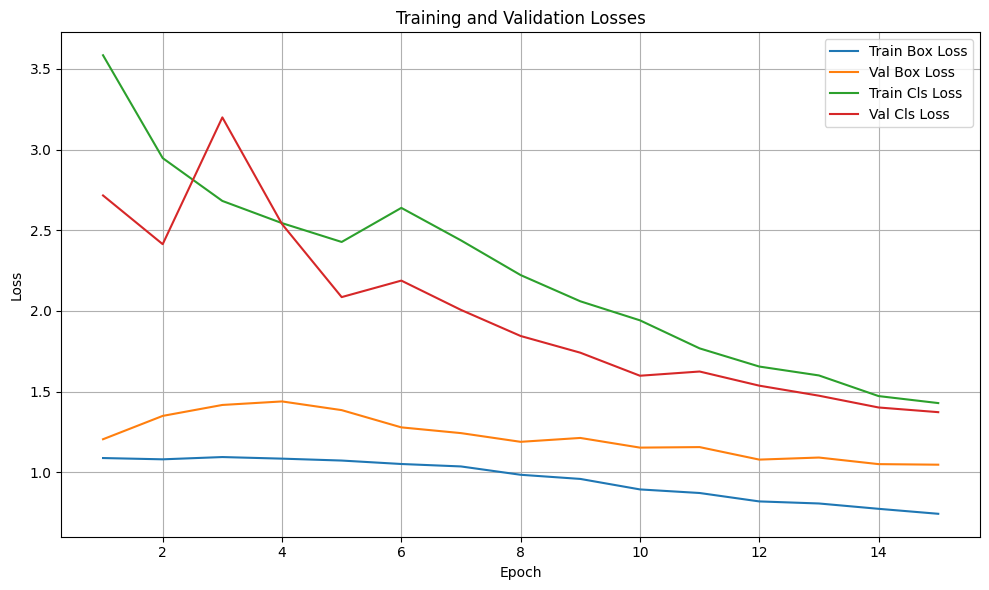

In [24]:
# import pandas as pd
# import matplotlib.pyplot as plt

# def plot_all_losses(results_csv_path):
#     df = pd.read_csv(results_csv_path)
#     epochs = df['epoch'] if 'epoch' in df.columns else df[df.columns[0]]

#     plt.figure(figsize=(10, 6))
#     plt.plot(epochs, df['train/box_loss'], label='Train Box Loss')
#     plt.plot(epochs, df['val/box_loss'], label='Val Box Loss')
#     plt.plot(epochs, df['train/cls_loss'], label='Train Cls Loss')
#     plt.plot(epochs, df['val/cls_loss'], label='Val Cls Loss')

#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.title("Training and Validation Losses")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Update this path based on output
# csv_path = "/kaggle/working/threat_balanced_training/yolov8_balanced/results.csv"
# plot_all_losses(csv_path)

In [25]:
# model = YOLO("/kaggle/working/threat_balanced_training/yolov8_balanced/weights/best.pt")

# metrics = model.val(data=str(data_yaml), split='test')

# print("✅ Evaluation Results:")
# print(f"mAP50: {metrics.box.map50:.4f}")
# print(f"mAP50-95: {metrics.box.map:.4f}")

# precision = sum(metrics.box.p) / len(metrics.box.p)
# recall = sum(metrics.box.r) / len(metrics.box.r)
# f1 = sum(metrics.box.f1) / len(metrics.box.f1)

# print(f"Precision (mean): {precision:.4f}")
# print(f"Recall (mean): {recall:.4f}")
# print(f"F1-score (mean): {f1:.4f}")

Ultralytics 8.3.136 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1011.1±124.4 MB/s, size: 61.5 KB)


val: Scanning /kaggle/working/balanced_dataset/test/labels... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1442.14it/s]

val: New cache created: /kaggle/working/balanced_dataset/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]


                   all        200        220       0.57      0.622      0.628       0.44
         civilian_auto         21         22      0.634      0.727      0.688      0.373
          civilian_bus         17         20      0.559       0.76      0.786      0.552
        civilian_tempo         20         22      0.679      0.636      0.786      0.532
      civilian_tractor         19         20       0.66        0.6      0.674      0.369
        civilian_truck         17         21      0.518      0.333      0.438      0.296
               safe_av         20         20      0.671        0.7      0.732      0.558
            safe_tanks         24         24      0.572      0.781      0.641      0.449
            safe_truck         18         21      0.542       0.81      0.639      0.506
             threat_av         10         11      0.506      0.364      0.472      0.378
           threat_tank         18         18      0.435      0.611       0.49      0.399
          threat_truc

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.7ms preprocess, 3.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val
✅ Evaluation Results:
mAP50: 0.6282
mAP50-95: 0.4397
Precision (mean): 0.5705
Recall (mean): 0.6224
F1-score (mean): 0.5864


In [28]:
model = YOLO("/kaggle/working/threat_balanced_training/yolov8_balanced/weights/best.pt")
model.export(format="torchscript")  # ✅ This is supported!

Ultralytics 8.3.136 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/kaggle/working/threat_balanced_training/yolov8_balanced/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 15, 8400) (6.0 MB)

TorchScript: starting export with torch 2.6.0+cu124...
TorchScript: export success ✅ 1.7s, saved as '/kaggle/working/threat_balanced_training/yolov8_balanced/weights/best.torchscript' (11.9 MB)

Export complete (3.3s)
Results saved to /kaggle/working/threat_balanced_training/yolov8_balanced/weights
Predict:         yolo predict task=detect model=/kaggle/working/threat_balanced_training/yolov8_balanced/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=/kaggle/working/threat_balanced_tr

'/kaggle/working/threat_balanced_training/yolov8_balanced/weights/best.torchscript'